In [1]:
# import libraries
import numpy as np
from sklearn import preprocessing
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import pickle

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
# convert numpy array to tensor
def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

In [10]:
# normal training loop
def train_data_driven(model, n_epochs):
    optimizer = tf.keras.optimizers.Adam()

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss = tf.reduce_mean((NN_output - y)**2)

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

#         if epoch % 100 == 0:
#             print("Training loss: ", loss)

    return model

In [9]:
# physics-informed training loop
def train(model, n_epochs, x_collocation):
    optimizer = tf.keras.optimizers.Adam()

    mean_X = to_tensor(scaler_X_batch.mean_)
    std_X = to_tensor(np.sqrt(scaler_X_batch.var_))
    mean_y = to_tensor(scaler_y_batch.mean_)
    std_y = to_tensor(np.sqrt(scaler_y_batch.var_))

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss1 = K.mean((NN_output[:, :, :] - y[:, :, :])**2)

                NN_output = model(x_collocation)

                CA_NN_input = x_collocation[:, :, 1] * std_X[1] + mean_X[1] + C_As
                T_NN_input = x_collocation[:, :, 0] * std_X[0] + mean_X[0] + T_s
                Q = x_collocation[:, :, 2] * std_X[2] + mean_X[2] + Q_s_new_batch

                NN_output = NN_output * std_y + mean_y + to_tensor(np.array([T_s, C_As]))

                dCA_first = (NN_output[:, 1:2, 1] - CA_NN_input[:, 0:1]) / (2*t_step*50)
                dT_first = (NN_output[:, 1:2, 0] - T_NN_input[:, 0:1]) / (2*t_step*50)

                dCA_center = (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2*t_step*50)
                dT_center = (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2*t_step*50)

                dCA_last = (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step*50)
                dT_last = (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step*50)

                dCA = K.concatenate((dCA_first, dCA_center, dCA_last), 1)
                dT = K.concatenate((dT_first, dT_center, dT_last), 1)

                lossCA = dCA + k_0 * K.exp(-E / (R * NN_output[:, :, 0])) * NN_output[:, :, 1]
                lossCA = K.mean(lossCA**2)

                lossT = dT + delta_H / (rho_L * C_p) * k_0 * K.exp(-E / (R * NN_output[:, :, 0])) * NN_output[:, :, 1] - Q / (rho_L * C_p * V_new_batch)
                lossT = K.mean(lossT**2)

                loss = 1e3 * loss1 + 1e-2 * lossCA + 1e-5 * lossT

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

#         if epoch % 100 == 0:
#             print("Training loss: ", loss)

    return model

In [11]:
# define neural network model
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, return_sequences=True)
        self.layer_2 = SimpleRNN(64, return_sequences=True)
        self.layer_3 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [17]:
# load the unseen datasets
with open('x_batch_5.pkl', 'rb') as f:
    x_all = pickle.load(f)

with open('y_batch_5.pkl', 'rb') as f:
    y_all = pickle.load(f)
    
with open('x_batch_scaler_5.pkl', 'rb') as f:
    scaler_X_batch = pickle.load(f)

with open('y_batch_scaler_5.pkl', 'rb') as f:
    scaler_y_batch = pickle.load(f)
    
with open('V_new_batch_5.pkl', 'rb') as f:
    V_new_batch = pickle.load(f)

with open('Q_s_new_batch_5.pkl', 'rb') as f:
    Q_s_new_batch = pickle.load(f)

# check mean and variance of batch generated
print(scaler_X_batch.mean_)
print(scaler_X_batch.var_)
print(scaler_y_batch.mean_)
print(scaler_y_batch.var_)

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# prepare collocation data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=100)
x_collocation = x_all[sample_idx]
x_collocation = to_tensor(x_collocation)

# k-shot learning on unseen task wrt 500 epochs per shot
num_shots = 50
test_loss_normal = np.zeros(num_shots)
test_loss_transfer = np.zeros(num_shots)
test_loss_reptile = np.zeros(num_shots)
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

for i in range(num_shots):
    
    print("No. of shots: ", i+1)

    # prepare training data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_train = x_all[sample_idx]
    y_train = y_all[sample_idx]

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 1000
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 1000
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

    # initialize model for data-driven training
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_normal[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of data-driven: ", test_loss_normal[i])

    # initialize model for transfer learning
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_transfer_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_transfer[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of transfer learning: ", test_loss_transfer[i])

    # initialize model for reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train_data_driven(model, n_epochs)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of reptile: ", test_loss_reptile[i])

# save results
np.savetxt("test_loss_normal_batch_5.txt", test_loss_normal, fmt='%f', delimiter=" ")
np.savetxt("test_loss_transfer_batch_5.txt", test_loss_transfer, fmt='%f', delimiter=" ")
np.savetxt("test_loss_reptile_batch_5.txt", test_loss_reptile, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_batch_5.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_batch_5.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

[-2.28847564e-01  5.36523277e-03 -4.69814423e+02 -4.69814423e+02]
[1.41772096e+03 7.03336648e-01 1.01890782e+11 1.01890782e+11]
[45.61055372 -1.03635119]
[3.61960257e+03 1.28535166e+00]
No. of shots:  1
Testing loss of PI-reptile:  0.12182116508483887
Testing loss of PI:  0.9506168961524963
Testing loss of data-driven:  0.6933165788650513
Testing loss of transfer learning:  0.5194900631904602
Testing loss of reptile:  0.46187642216682434
No. of shots:  2
Testing loss of PI-reptile:  0.12055834382772446
Testing loss of PI:  0.2732371687889099
Testing loss of data-driven:  0.7558224201202393
Testing loss of transfer learning:  0.4690520465373993
Testing loss of reptile:  0.44264620542526245
No. of shots:  3
Testing loss of PI-reptile:  0.19725416600704193
Testing loss of PI:  0.19011858105659485
Testing loss of data-driven:  0.4823974072933197
Testing loss of transfer learning:  0.3466746211051941
Testing loss of reptile:  0.32987770438194275
No. of shots:  4
Testing loss of PI-reptile: 

Testing loss of reptile:  0.016773609444499016
No. of shots:  32
Testing loss of PI-reptile:  0.005324903875589371
Testing loss of PI:  0.020790157839655876
Testing loss of data-driven:  0.012375821359455585
Testing loss of transfer learning:  0.08921884745359421
Testing loss of reptile:  0.01770930550992489
No. of shots:  33
Testing loss of PI-reptile:  0.004892557393759489
Testing loss of PI:  0.019984809681773186
Testing loss of data-driven:  0.025331737473607063
Testing loss of transfer learning:  0.1157279759645462
Testing loss of reptile:  0.012722806073725224
No. of shots:  34
Testing loss of PI-reptile:  0.005041163414716721
Testing loss of PI:  0.01499929279088974
Testing loss of data-driven:  0.02014949545264244
Testing loss of transfer learning:  0.09992112219333649
Testing loss of reptile:  0.012988246977329254
No. of shots:  35
Testing loss of PI-reptile:  0.005133798345923424
Testing loss of PI:  0.01965305581688881
Testing loss of data-driven:  0.02613980323076248
Testin

In [60]:
# get mean and std
test_loss_reptile_batch_1 = np.loadtxt("test_loss_reptile_batch_1.txt")
test_loss_reptile_batch_2 = np.loadtxt("test_loss_reptile_batch_2.txt")
test_loss_reptile_batch_3 = np.loadtxt("test_loss_reptile_batch_3.txt")
test_loss_reptile_batch_4 = np.loadtxt("test_loss_reptile_batch_4.txt")
test_loss_reptile_batch_5 = np.loadtxt("test_loss_reptile_batch_5.txt")

test_loss_reptile_batch_mean = np.mean((test_loss_reptile_batch_1, test_loss_reptile_batch_2, test_loss_reptile_batch_3, test_loss_reptile_batch_4, test_loss_reptile_batch_5), axis=0)
test_loss_reptile_batch_std = np.std((test_loss_reptile_batch_1, test_loss_reptile_batch_2, test_loss_reptile_batch_3, test_loss_reptile_batch_4, test_loss_reptile_batch_5), axis=0)

test_loss_transfer_batch_1 = np.loadtxt("test_loss_transfer_batch_1.txt")
test_loss_transfer_batch_2 = np.loadtxt("test_loss_transfer_batch_2.txt")
test_loss_transfer_batch_3 = np.loadtxt("test_loss_transfer_batch_3.txt")
test_loss_transfer_batch_4 = np.loadtxt("test_loss_transfer_batch_4.txt")
test_loss_transfer_batch_5 = np.loadtxt("test_loss_transfer_batch_5.txt")

test_loss_transfer_batch_mean = np.mean((test_loss_transfer_batch_1, test_loss_transfer_batch_2, test_loss_transfer_batch_3, test_loss_transfer_batch_4, test_loss_transfer_batch_5), axis=0)
test_loss_transfer_batch_std = np.std((test_loss_transfer_batch_1, test_loss_transfer_batch_2, test_loss_transfer_batch_3, test_loss_transfer_batch_4, test_loss_transfer_batch_5), axis=0)

test_loss_normal_batch_1 = np.loadtxt("test_loss_normal_batch_1.txt")
test_loss_normal_batch_2 = np.loadtxt("test_loss_normal_batch_2.txt")
test_loss_normal_batch_3 = np.loadtxt("test_loss_normal_batch_3.txt")
test_loss_normal_batch_4 = np.loadtxt("test_loss_normal_batch_4.txt")
test_loss_normal_batch_5 = np.loadtxt("test_loss_normal_batch_5.txt")

test_loss_normal_batch_mean = np.mean((test_loss_normal_batch_1, test_loss_normal_batch_2, test_loss_normal_batch_3, test_loss_normal_batch_4, test_loss_normal_batch_5), axis=0)
test_loss_normal_batch_std = np.std((test_loss_normal_batch_1, test_loss_normal_batch_2, test_loss_normal_batch_3, test_loss_normal_batch_4, test_loss_normal_batch_5), axis=0)

test_loss_PI_batch_1 = np.loadtxt("test_loss_PI_batch_1.txt")
test_loss_PI_batch_2 = np.loadtxt("test_loss_PI_batch_2.txt")
test_loss_PI_batch_3 = np.loadtxt("test_loss_PI_batch_3.txt")
test_loss_PI_batch_4 = np.loadtxt("test_loss_PI_batch_4.txt")
test_loss_PI_batch_5 = np.loadtxt("test_loss_PI_batch_5.txt")

test_loss_PI_batch_mean = np.mean((test_loss_PI_batch_1, test_loss_normal_batch_2, test_loss_normal_batch_3, test_loss_PI_batch_4, test_loss_PI_batch_5), axis=0)
test_loss_PI_batch_std = np.std((test_loss_PI_batch_1, test_loss_normal_batch_2, test_loss_normal_batch_3, test_loss_PI_batch_4, test_loss_PI_batch_5), axis=0)

test_loss_PI_reptile_batch_1 = np.loadtxt("test_loss_PI_reptile_batch_1.txt")
test_loss_PI_reptile_batch_2 = np.loadtxt("test_loss_PI_reptile_batch_2.txt")
test_loss_PI_reptile_batch_3 = np.loadtxt("test_loss_PI_reptile_batch_3.txt")
test_loss_PI_reptile_batch_4 = np.loadtxt("test_loss_PI_reptile_batch_4.txt")
test_loss_PI_reptile_batch_5 = np.loadtxt("test_loss_PI_reptile_batch_5.txt")

test_loss_PI_reptile_batch_mean = np.mean((test_loss_PI_reptile_batch_1, test_loss_PI_reptile_batch_2, test_loss_PI_reptile_batch_3, test_loss_PI_reptile_batch_4, test_loss_PI_reptile_batch_5), axis=0)
test_loss_PI_reptile_batch_std = np.std((test_loss_PI_reptile_batch_1, test_loss_PI_reptile_batch_2, test_loss_PI_reptile_batch_3, test_loss_PI_reptile_batch_4, test_loss_PI_reptile_batch_5), axis=0)

In [61]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

meta NOT subset; don't know how to subset; dropped


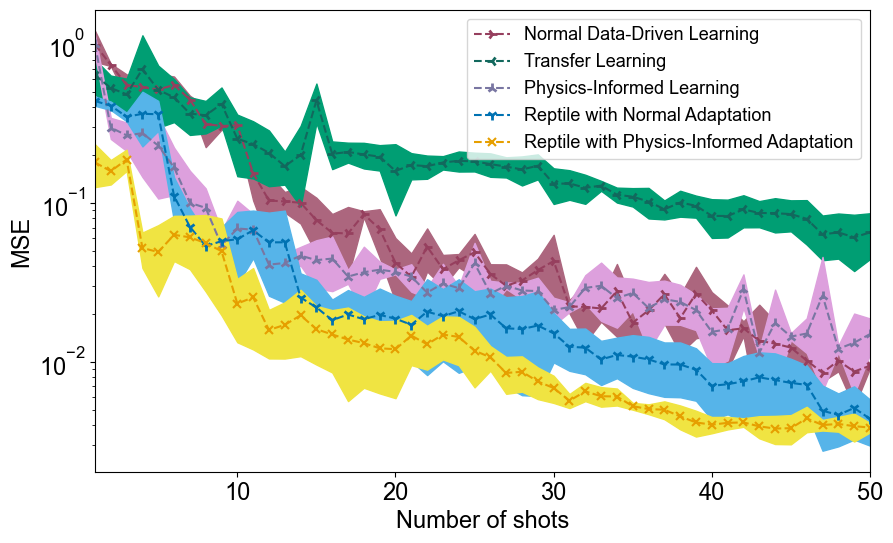

In [63]:
# Testing
test_loss_reference = [0.0099]

size = 50
x = np.arange(1,size+1,1)

plt.figure(figsize=(10,6))
plt.rc('font', size=17)

plt.plot(x, test_loss_normal_batch_mean[:size], '--', color='#963F5E', marker='4', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Normal Data-Driven Learning')
plt.fill_between(x, test_loss_normal_batch_mean[:size] - test_loss_normal_batch_std[:size], test_loss_normal_batch_mean[:size] + test_loss_normal_batch_std[:size], edgecolor="#AC667E", facecolor="#AC667E")

plt.plot(x, test_loss_transfer_batch_mean[:size], '--', color='#12685D', marker='3', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Transfer Learning')
plt.fill_between(x, test_loss_transfer_batch_mean[:size] - test_loss_transfer_batch_std[:size], test_loss_transfer_batch_mean[:size] + test_loss_transfer_batch_std[:size], edgecolor="#009E73", facecolor="#009E73")

plt.plot(x, test_loss_PI_batch_mean[:size], '--', color='#7976A2', marker='2', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Physics-Informed Learning')
plt.fill_between(x, test_loss_PI_batch_mean[:size] - test_loss_PI_batch_std[:size], test_loss_PI_batch_mean[:size] + test_loss_PI_batch_std[:size], edgecolor="plum", facecolor="plum")

plt.plot(x, test_loss_reptile_batch_mean[:size], '--', color='#0072B2', marker='1', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Reptile with Normal Adaptation')
plt.fill_between(x, test_loss_reptile_batch_mean[:size] - test_loss_reptile_batch_std[:size], test_loss_reptile_batch_mean[:size] + test_loss_reptile_batch_std[:size], edgecolor="#56B4E9", facecolor="#56B4E9")

plt.plot(x, test_loss_PI_reptile_batch_mean[:size], '--', color='#E69F00', marker='x', linewidth=1.5, markersize=5.5, markeredgewidth=1.5, label='Reptile with Physics-Informed Adaptation')
plt.fill_between(x, test_loss_PI_reptile_batch_mean[:size] - test_loss_PI_reptile_batch_std[:size], test_loss_PI_reptile_batch_mean[:size] + test_loss_PI_reptile_batch_std[:size], edgecolor="#F0E442", facecolor="#F0E442")

# plt.plot(x, test_loss_reference*(size), color='#E47159', linewidth=1.5, label='Reference MSE')

plt.legend(fontsize=13)
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.yscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('batch_fewshots.pdf')
plt.show()